In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc, make_scorer, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

In [2]:
# 加载数据
data = pd.read_excel('../西二线干线/paper_data/A1_finish_data.xlsx')
data = data.fillna(0)

In [3]:


X = data.drop(columns=['target'])

y = data['target']
X_columns = X.columns.tolist()

random_seed = 42

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=random_seed)

# 使用SMOTE方法进行过采样
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
# 确认训练集的正例和负例是否平衡
print(y_train.value_counts())

0    378
1    378
Name: target, dtype: int64


In [4]:
# 优化RandomForestClassifier参数
# n_estimators,max_samples,max_depth,

# 初始范围 
# n_estimators = list(range(5, 120, 5))
# max_samples_list = np.arange(0.05, 1, 0.05)
# max_depths_list = list(range(5, 26, 1))

# 优化
# 优化目标： 1、最大化accuracy；   2、最大化f1_score；   3、最小化log_loss；   4、最大化auc；
# 优化方法：随机搜索

# 可视化
# 首先将四个优化目标降至一维称为opt_goal；
# 其次将（max_samples，max_depths）降至一维称为参数comph_pars;
# 最后对n_estimators；comph_pars；opt_goal归一化；
# 1、三维-(x轴为n_estimators；y轴为comph_pars；z轴为opt_goal)

In [5]:
# 定义参数空间
param_dist = {
    'n_estimators': list(range(5, 120, 5)),
    'max_samples': np.arange(0.05, 1, 0.05),
    'max_depth': list(range(5, 26, 1))
}

# 定义优化目标
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'log_loss': make_scorer(log_loss, greater_is_better=False),
    'auc': make_scorer(roc_auc_score),
}

# 初始化随机森林分类器
clf = RandomForestClassifier(random_state=random_seed)

# 初始化随机搜索
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, scoring=scoring, refit=False, n_iter=50, cv=5, random_state=random_seed)

random_search.fit(X_train, y_train)

results = pd.DataFrame(random_search.cv_results_)

# 使用PCA将四个优化目标降至一维
pca = PCA(n_components=1)
results['opt_goal'] = pca.fit_transform(results[['mean_test_accuracy', 'mean_test_f1', 'mean_test_log_loss', 'mean_test_auc']])

# 使用PCA将max_samples和max_depths降至一维
results['comph_pars'] = pca.fit_transform(results[['param_max_samples', 'param_max_depth']])

# 对n_estimators，comph_pars，opt_goal归一化
scaler = MinMaxScaler()
results[['param_n_estimators', 'comph_pars', 'opt_goal']] = scaler.fit_transform(results[['param_n_estimators', 'comph_pars', 'opt_goal']])

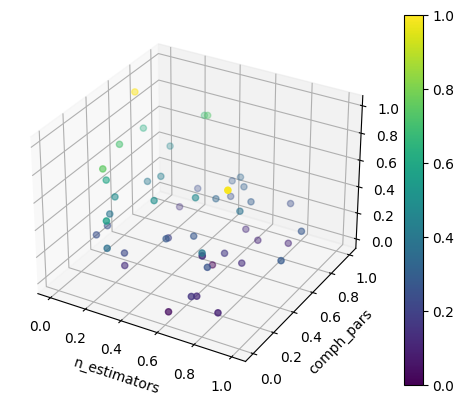

In [6]:
# 三维可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(results['param_n_estimators'], results['comph_pars'], results['opt_goal'], c=results['opt_goal'], cmap='viridis')
ax.set_xlabel('n_estimators')
ax.set_ylabel('comph_pars')
ax.set_zlabel('opt_goal')
fig.colorbar(p)
fig.savefig('paper_figure/3-3-1opt_randomfor.svg')
plt.show()

In [7]:
# 找到opt_goal最大的那一行
best_row = results.loc[results['opt_goal'].idxmax()]

# 找到对应的n_estimators，max_samples，max_depths
best_n_estimators = best_row['param_n_estimators']
best_max_samples = best_row['param_max_samples']
best_max_depths = best_row['param_max_depth']

In [8]:
rf_best_params = best_row.params

In [9]:
# 优化CatBoostClassifier参数
# iterations,learning_rate

# 初始范围 
# iterations = list(range(100, 2000, 100))
# learning_rate = np.arange(0.005, 0.11, 0.005)

# 优化
# 优化目标： 1、最大化accuracy；   2、最大化f1_score；   3、最小化log_loss；   4、最大化auc；
# 优化方法：网格法

# 可视化
# 首先将四个优化目标降至一维称为opt_goal；
# 其次对n_estimators；comph_pars；opt_goal归一化；
# 1、三维-(x轴为iterations；y轴为learning_rate；z轴为opt_goal)


# 计算时间：约半个小时

In [20]:
# 设置参数网格
param_grid = {
    'iterations': list(range(100, 700, 100)),
    'learning_rate': np.arange(0.002, 0.022, 0.002)
}

# 设置优化目标
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
# 'log_loss': make_scorer(log_loss, greater_is_better=False),
    'auc': make_scorer(roc_auc_score),
}

# 进行参数优化
clf = CatBoostClassifier(random_seed=random_seed, verbose=0)
grid_search = GridSearchCV(clf,
                           param_grid,
                           scoring=scoring,
                           refit=False
                           #cv=4
                          )
grid_search.fit(X_train, y_train)

# 获取结果
results = pd.DataFrame(grid_search.cv_results_)

In [21]:

# 将四个优化目标降至一维
pca = PCA(n_components=1)
results['opt_goal'] = pca.fit_transform(results[[
    'mean_test_accuracy', 'mean_test_f1_score', 
    #'mean_test_log_loss',
    'mean_test_auc'
]])

# 对n_estimators，learning_rate，opt_goal进行归一化
scaler = MinMaxScaler()
results[['param_iterations', 'param_learning_rate',
         'opt_goal']] = scaler.fit_transform(
             results[['param_iterations', 'param_learning_rate', 'opt_goal']])

# 找到opt_goal最大的那一行
best_row = results.loc[results['opt_goal'].idxmax()]

# 找到对应的iterations和learning_rate
best_iterations = best_row['param_iterations']
best_learning_rate = best_row['param_learning_rate']

In [22]:
print(results.columns)
boost_best_params = best_row.params


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_iterations', 'param_learning_rate', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_test_f1_score',
       'split1_test_f1_score', 'split2_test_f1_score', 'split3_test_f1_score',
       'split4_test_f1_score', 'mean_test_f1_score', 'std_test_f1_score',
       'rank_test_f1_score', 'split0_test_auc', 'split1_test_auc',
       'split2_test_auc', 'split3_test_auc', 'split4_test_auc',
       'mean_test_auc', 'std_test_auc', 'rank_test_auc', 'opt_goal'],
      dtype='object')


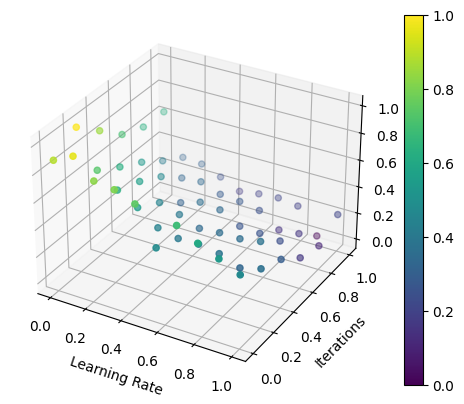

In [23]:
# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
scatter = ax.scatter(results['param_learning_rate'], results['param_iterations'], results['opt_goal'], c=results['opt_goal'], cmap='viridis')

# 添加颜色条
fig.colorbar(scatter)

# 设置轴标签
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Iterations')
ax.set_zlabel('Opt Goal')

# 保存图像
fig.savefig('paper_figure/3-3-2opt_catboost_ite50_lea_rate0001.svg')
# 显示图
plt.show()

In [24]:
# 获取结果
results = pd.DataFrame(grid_search.cv_results_)

# 保存结果到Excel
results.to_excel("paper_data/catboost_grid_search_results.xlsx", index=False)

In [25]:
# 从Excel读取结果
results = pd.read_excel("paper_data/catboost_grid_search_results.xlsx")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_iterations,param_learning_rate,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_test_auc,split1_test_auc,split2_test_auc,split3_test_auc,split4_test_auc,mean_test_auc,std_test_auc,rank_test_auc
0,0.289623,0.008178,0.009070,0.000525,100,0.002,"{'iterations': 100, 'learning_rate': 0.002}",0.598684,0.708609,0.874172,0.847682,0.874172,0.780664,0.109807,58,0.702439,0.750000,0.861314,0.832117,0.863309,0.801836,0.064498,58,0.598684,0.707544,0.874825,0.847105,0.873684,0.780368,0.109906,58
1,0.284127,0.003183,0.009106,0.000539,100,0.004,"{'iterations': 100, 'learning_rate': 0.004}",0.565789,0.721854,0.880795,0.841060,0.867550,0.775410,0.118924,59,0.688679,0.758621,0.867647,0.823529,0.855072,0.798710,0.066722,59,0.565789,0.720877,0.881491,0.840439,0.867018,0.775123,0.118986,59
2,0.285863,0.006461,0.023189,0.027924,100,0.006,"{'iterations': 100, 'learning_rate': 0.006}",0.559211,0.715232,0.894040,0.867550,0.880795,0.783365,0.129395,56,0.685446,0.754286,0.884058,0.850746,0.869565,0.808820,0.076555,56,0.559211,0.714211,0.894649,0.866842,0.880263,0.783035,0.129436,56
3,0.283245,0.003955,0.009229,0.000407,100,0.008,"{'iterations': 100, 'learning_rate': 0.008}",0.559211,0.695364,0.907285,0.860927,0.894040,0.783365,0.135359,55,0.691244,0.738636,0.900000,0.846715,0.885714,0.812462,0.082881,55,0.559211,0.694298,0.907807,0.860351,0.893596,0.783053,0.135456,55
4,0.282696,0.002674,0.009061,0.000464,100,0.010,"{'iterations': 100, 'learning_rate': 0.01}",0.552632,0.715232,0.913907,0.854305,0.900662,0.787348,0.136845,54,0.685185,0.757062,0.906475,0.838235,0.892086,0.815809,0.083732,54,0.552632,0.714123,0.914474,0.853684,0.900175,0.787018,0.136927,54


{'iterations': 200, 'learning_rate': 0.002}

In [27]:
rf_best_params

{'n_estimators': 10, 'max_samples': 0.25, 'max_depth': 12}

In [28]:
boost_best_params

{'iterations': 200, 'learning_rate': 0.002}